# Optimizing a tiger IFU in the diffration-limited regime
*A. Bolton, 2023 May*


<span style="color:red">
    <span style="font-weight:bold">
        Disclaimer: the results of this notebook are sensitive to numerical sampling choices / aliasing in some regimes, and should be viewed as preliminary.
    </span>
</span>

<br>

**tl;dr: You can mostly get well-behaved tiger PSFs if you zoom in to the minimum FOV limit of 0.7$\times$0.7 arcsec with 12 milliarcsec spaxels,
although things will still be dicey at the 0.4$\mu$m lower wavelength limit. For
coarser spaxel angular sampling, you'll be in the transitional regime between geometric
and diffraction-dominated, for which the tiger PSFs are an ugly mess.**


### Origin of the problem

The Tiger IFU spectrograph design is based on using a microlens array to image the telescope pupil into a grid of small and well-separated "micropupil" images, and then  dispersing these images at a slight angle to the grid so that the resulting spectra don't overlap with each other.

In the ground-based seeing-limited regime, a microlens array that critically samples the seeing will produce well-resolved micropupil images. *In the space-based diffraction-limited regime, a microlens array that critically samples the PSF will produce only marginally resolved micropupil images.*

Why is this?

The telescope angular resolution on the sky is $\lambda / D$ (where $D$ is primary diameter) and the lenslet subtends an angle $d / f$ on the sky (where $d$ is the microlens size and $f$ is the effective telescope focal length). So the condition for marginal sampling of the telescope psf is $d / f \sim \lambda / D$.

At the same time, the microlens diffraction limit is $\lambda / d$ and the pupil subtends an angle $D / f$ as seen by the microlens. So the condition for the pupil to be marginally resolved by the microlens is $\lambda / d \sim D / f$. *This is the same condition as above: $dD \sim \lambda f$.*

Why is this a problem?

*Because (as we will see below) the microimages get very ugly in the regime where the scale of the pupil and the scale of microlens diffraction become comparable.* The tiger PSFs in this regime have...
 * Larger size
 * More complicated shape
 * Greater variation with wavelength
 * Greater variation with location of telescope PSF relative to microlens

### A possible solution

The geometric pupil regime is nicely behaved in a Tiger IFU. *But the only way to work in the geometric regime is to vastly undersample the diffraction-limited telescope PSF!* (Which kind of defeats the purpose...)

The transitional regime is a mess as noted above (and illustrated below).

So, can we work in the fully *uresolved* pupil regime? In this regime, the microlens array will not generate micropupil images, but rather square-aperture diffraction patterns. (And for many purposes we can compute those analytically!)

This notebook first explores a Tiger design that attempts to meet requirements while working as fully in this micro-diffraction regime as possible, then shows what happens when it is pushed into the transitional regime
where things get ugly.

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
#from poppy.sub_sampled_optics import Subapertures, ShackHartmannWavefrontSensor
import astropy.units as u
import astropy.io.fits as fits
import copy
#from astropy.table import Table, QTable
import skimage.measure

### What knobs can we turn, and how should we turn them?
The only way to get into the regime of a pupil that is unresolved by the microlens array is to push
towards spaxels of smaller angular scale on the sky. All other things being equal, this will push towards
a smaller IFU field of view.

Taking 0.7$\times$0.7 arcsec as the smallest permissible FOV, and 59 lenslets as the maximum number that can be fit across a 4096$^2$ detector with 10$\mu$m pixels (discussed elsewhere), we find a physical lenslet size of 694$\mu$m subtending a spaxel size of 11.9 mas on the sky. This compares to a $\sim$12.7 mas diffration-limited imaging resolution at the shortest working wavelength of 0.4$\mu$m, which will be the most challenging. In an ideal world we'd like to go to finer sampling but we can't do that without either a bigger detector or a smaller FOV, so we'll see how this limit works out. This dictates the effective focal length from the combination of telescope plus magnifier.

The next knob is the focal length of the lenslet array, which will determine the size of the projected microimages. The square-aperture diffraction pattern is given by
$$ I(x,y) \propto \mathrm{sinc}^2 \left({{dx} \over {\lambda z}} \right) \mathrm{sinc}^2 \left({{dy} \over {\lambda z}} \right)$$
where $x$ and $y$ are coordinates in the microimage plane and $z$ is the distance from the microlens at which the microimage is formed. The physical half-width to the first zero in either direction is $\lambda z / d$. We will pick our microlens focal length to set this to be 10$\mu$m at a reference wavelength of 1$\mu$m. In considering other possible compromise values, the tradeoff is between the microimage becoming too big at longer wavelengths or too small at shorter wavelengths. Note also that pushing towards smaller microimages overall (via a shorter microlens focal length) will make for a faster diverging beam coming out of the MLA and entering the spectrograph, which could become problematic.

The last knob to consider is the "diaphragm" to mask the wings of the microimage. We will adopt a value that masks the wings beyond the third zero of the square-aperture diffraction pattern.

The following cells define our reference model, including the telescope upstream from the MLA and the spectrograph downstream. Note that we have to implement a large sampling buffer beyond the pupil, since we are computing in a regime where the pupil is (mostly) unresolved and the extent of the microimage is set by diffraction not by geometry.

Also note that we employ a small simulated "detector" with 1$\mu$m pixels that oversamples the actual detector pixels by a factor of 10, to show the detailed structure of the PSF.

### Specify model parameters

In [2]:
# Lenslet array parameters:
nl_dim = 59        # Number of lenslets across the array (smaller dimension)
fov_arcsec = 0.7   # Desired field-of-view of lenslet array (smaller dimension)
spaxel_arcsec = fov_arcsec / nl_dim  # Arcseconds per spaxel (COMPUTED)
det_size = 40960. * 1.e-6 * u.m      # Physical size of detector
spaxel_size = det_size / nl_dim      # Physical size of spaxel/lenslet (COMPUTED)

# Telescope:
diam = 6.5 * u.m       # primary aperture diameter
sec_rad = 0.65 * u.m   # secondary radius
n_supp = 3             # number of secondary supports
supp_wid = 0.15 * u.m  # width of secondary supports
fl_pri = spaxel_size / (spaxel_arcsec / 206265.) # Effective focal length you need to get plate scale

# Tiger MLA parameters:
ref_wave = 1.0e-6 * u.m   # Reference wavelength at which to specify sampling
hw_zero = 10.e-6 * u.m    # Desired image half-width to first zero of lenslet diffraction pattern
imdist_tiger = hw_zero * spaxel_size / ref_wave  # Desired image distance formed by lenslet (COMPUTED)
fl_tiger = 1./(1./imdist_tiger + 1./fl_pri) # Lenslet focal length (COMPUTED, very small correction!)

nz_mask = 3       # Number of zeros at reference wavelength beyond which to mask
dsize_tiger = 2 * nz_mask * hw_zero # Size of Tiger diaphragm mask aperture (COMPUTED)
microp_size = imdist_tiger * (diam / fl_pri) # Diameter of micropupil image (COMPUTED)

# Spectrograph parameters:
#### [for offset_m2 cf. zemax & np.hypot(358.20-182.96,85.545-59.665) = 177.14]
pr_dist = 175.477e-3 * u.m      # Distance to first surface of first prism (SOMETIMES USED)
roc_m1m3 = -351.4938e-3 * u.m   # Radius of curvature of (concave) m1 & m3
roc_m2 = 164.3909e-3 * u.m      # Radius of curvature of (convex) m2
fl_m1m3 = -0.5 * roc_m1m3       # Focal length of m1 & m3 (COMPUTED)
fl_m2 = -0.5 * roc_m2           # Focal length of m2 (COMPUTED)
offset_m2 = -roc_m1m3 - roc_m2  # Notional m2 offset from m1/m3 (COMPUTED)
imdist_spec = -roc_m1m3         # image/object-plane distances from m1 & m3 (COMPUTED)
dsize_m2 = 45.e-3 * u.m         # Diameter of m2
dsize_m1m3 = 270.e-3 * u.m      # Diameter of m1/m3 (CURRENTLY NOT USED)
fratio_spec = (imdist_spec - offset_m2) / dsize_m2 # sepctrograph focal ratio (COMPUTED, CURRENTLY NOT USED)

# Computational parameters:
npix = 2048              # number of pixels across pupil
pupil_diam = 10. * diam   # Diameter of area to sample <-- FIX??!

# "Detector" parameters:
detscale = 1.e-6 * u.m/u.pixel  # pixel scale of detector (nominal = 10um/pix; finer to super-resolve)
#detfov = 64 * u.pixel             # number of pixels across detector
detfov = 100 * u.pixel             # number of pixels across detector
#detfov = 2 * microp_size * (pupil_diam / diam) / detscale

### Display summary of parameters:

In [3]:
print("Telescope focal length (eff)   = ", fl_pri.to_string(precision=1))
print("Lenslet size                   = ", spaxel_size.to(u.micron).to_string(precision=1))
print("IFU field of view              = ", (fov_arcsec * u.arcsecond).to_string(precision=2))
print("Spaxel angular size on sky     = ", (1000.*spaxel_arcsec * u.milliarcsecond).to_string(precision=2))
print("N lenslets across array        = ", nl_dim)
print("Design reference wavelength    = ", ref_wave.to(u.micron).to_string(precision=2))
print("Microlens focal length         = ", fl_tiger.to(u.mm).to_string(precision=2))
print("Half-width to first micromin   = ", hw_zero.to(u.micron).to_string(precision=1))
print("Geometric size of micropupil   = ", microp_size.to(u.micron).to_string(precision=3))
print("Diaphragm aperture width       = ", dsize_tiger.to(u.micron).to_string(precision=1))
print("Microlens emerging f-ratio     = ", (imdist_tiger/spaxel_size).to_string(precision=1))

Telescope focal length (eff)   =  12069.4 m
Lenslet size                   =  694.2 micron
IFU field of view              =  0.70 arcsec
Spaxel angular size on sky     =  11.86 marcsec
N lenslets across array        =  59
Design reference wavelength    =  1.00 micron
Microlens focal length         =  6.94 mm
Half-width to first micromin   =  10.0 micron
Geometric size of micropupil   =  3.739 micron
Diaphragm aperture width       =  60.0 micron
Microlens emerging f-ratio     =  10.0


### Instantiate model

In [4]:
sys_tiger = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_tiger.add_optic(ttstage)
# Include secondary obscuration:
sys_tiger.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_tiger.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_tiger.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Tiger MLA aperture'))
# Add MLA lens:
sys_tiger.add_optic(poppy.QuadraticLens(fl_tiger, name='Tiger MLA lens'))
# Define micropupil image plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Tiger micropupil plane'),
                    distance=imdist_tiger)
# Add diaphragm mask:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_tiger,  ### <---FIX?!
                                          name='Tiger diaphragm mask'))
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add reference plane at location of first prism surface:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='First prism surface'),
                    distance=pr_dist)
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=(imdist_spec-pr_dist))
# Add spectrograph M2 aperture:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=imdist_spec)
# Add "detector":
sys_tiger.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_tiger.planes)):
    sys_tiger.planes[iplane].wavefront_display_hint = 'intensity'

### Centered PSF versus wavelength
The plots below show the delivered spectrograph PSF as a function of wavelength, for the case
of the *telescope* PSF centered in the lenslet.

Log plots are log-cumulative-histogram scaled.

Note in the first plot how you can see the pupil starting to "bloom" at 0.4$\mu$m.

In [5]:
test_lam = [this_lam * u.micron for this_lam in np.linspace(.4,1.7,14)]
psf_stack = []
for this_lam in test_lam:
    print(this_lam)
    this_psf, this_wave = sys_tiger.calc_psf(wavelength=this_lam, return_final=True)
    psf_stack.append(this_wave[0])

0.4 micron
0.5 micron
0.6 micron
0.7 micron
0.8 micron
0.8999999999999999 micron
1.0 micron
1.1 micron
1.2 micron
1.2999999999999998 micron
1.4 micron
1.5 micron
1.6 micron
1.7 micron


In [6]:
# Function to compute cumulative fraction of counts down to given surface brightness:
def cfrac_counts(image, minfrac=0.):
    outimg = image.ravel().copy()
    outshp = image.shape
    srt = np.flip(np.argsort(outimg))
    csum = outimg[srt].cumsum() / outimg.sum()
    outimg[srt] = np.maximum(1. - csum, minfrac)
    outimg.resize(outshp)
    return(outimg)

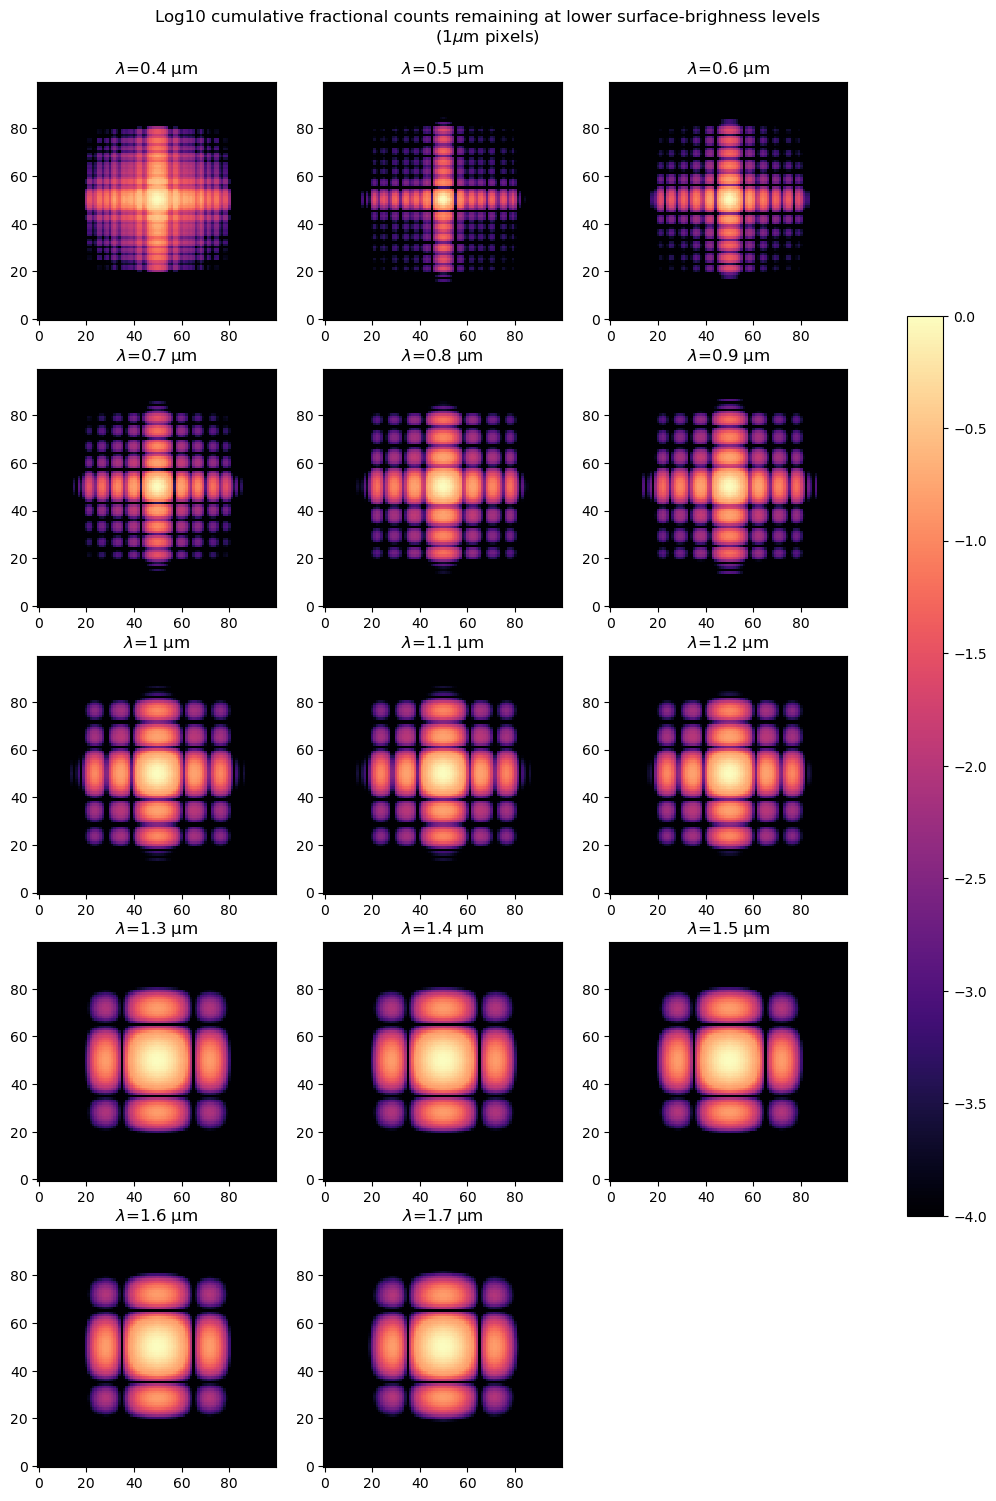

In [7]:
# Make unbinned plot:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = cfrac_counts(psf_stack[k].intensity, minfrac=1.e-10)
    ax = axis[j,i].imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Log10 cumulative fractional counts remaining at lower surface-brighness levels\n' +
                    '(1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

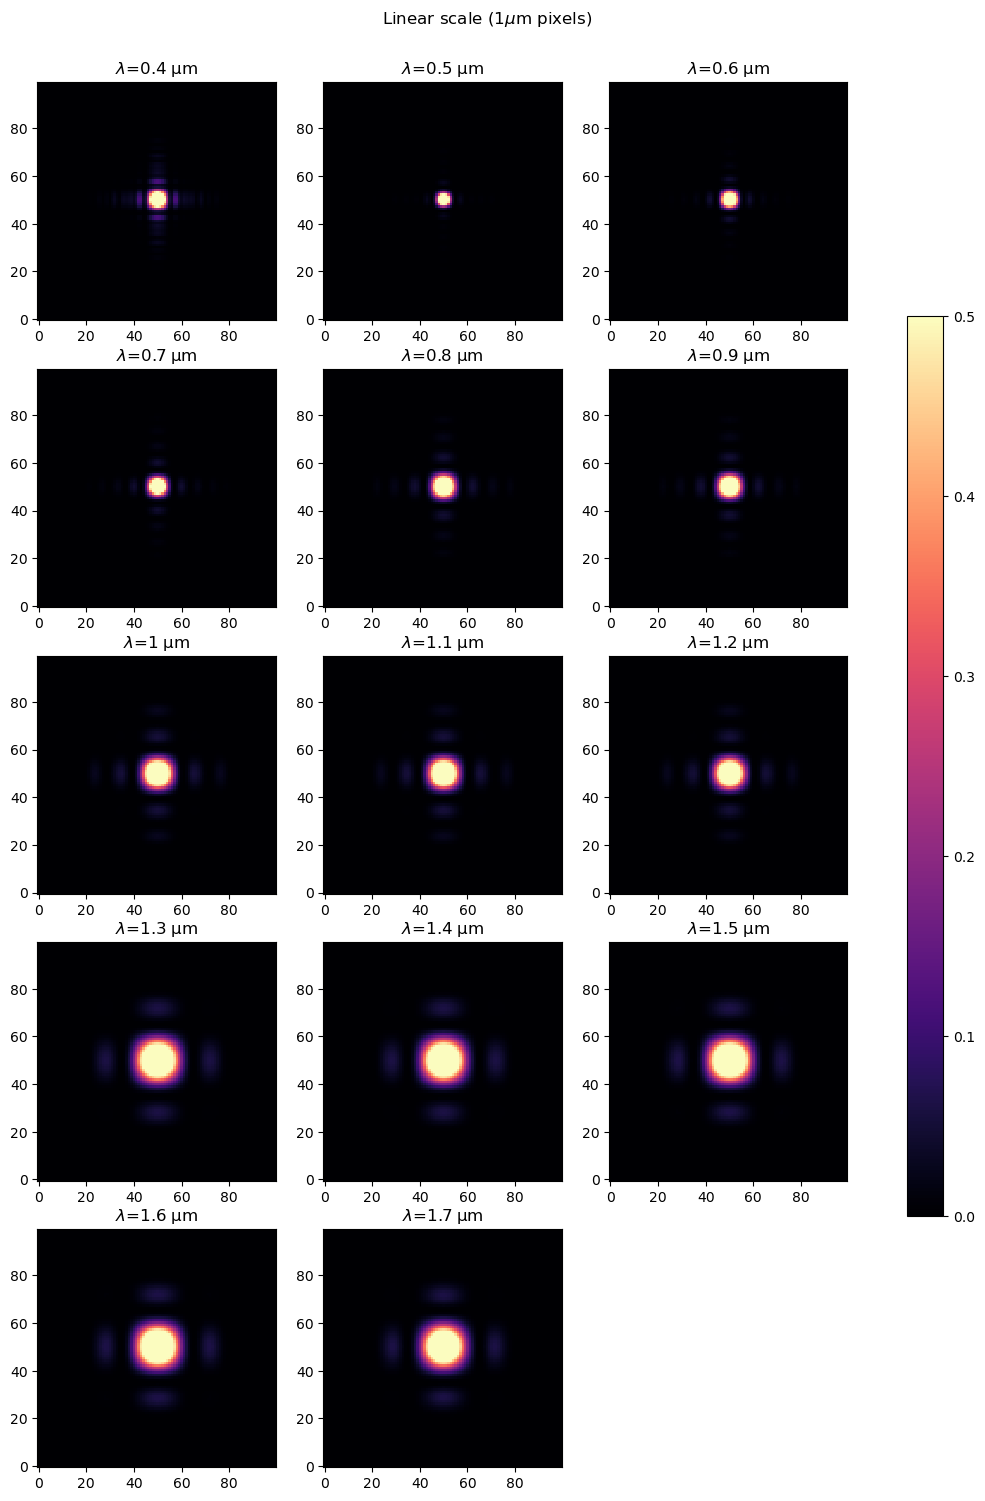

In [18]:
# Same plot, linear:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = psf_stack[k].intensity / psf_stack[k].intensity.max()
    ax = axis[j,i].imshow(disp_image, cmap='magma', vmin=0., vmax=0.5, interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Linear scale (1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

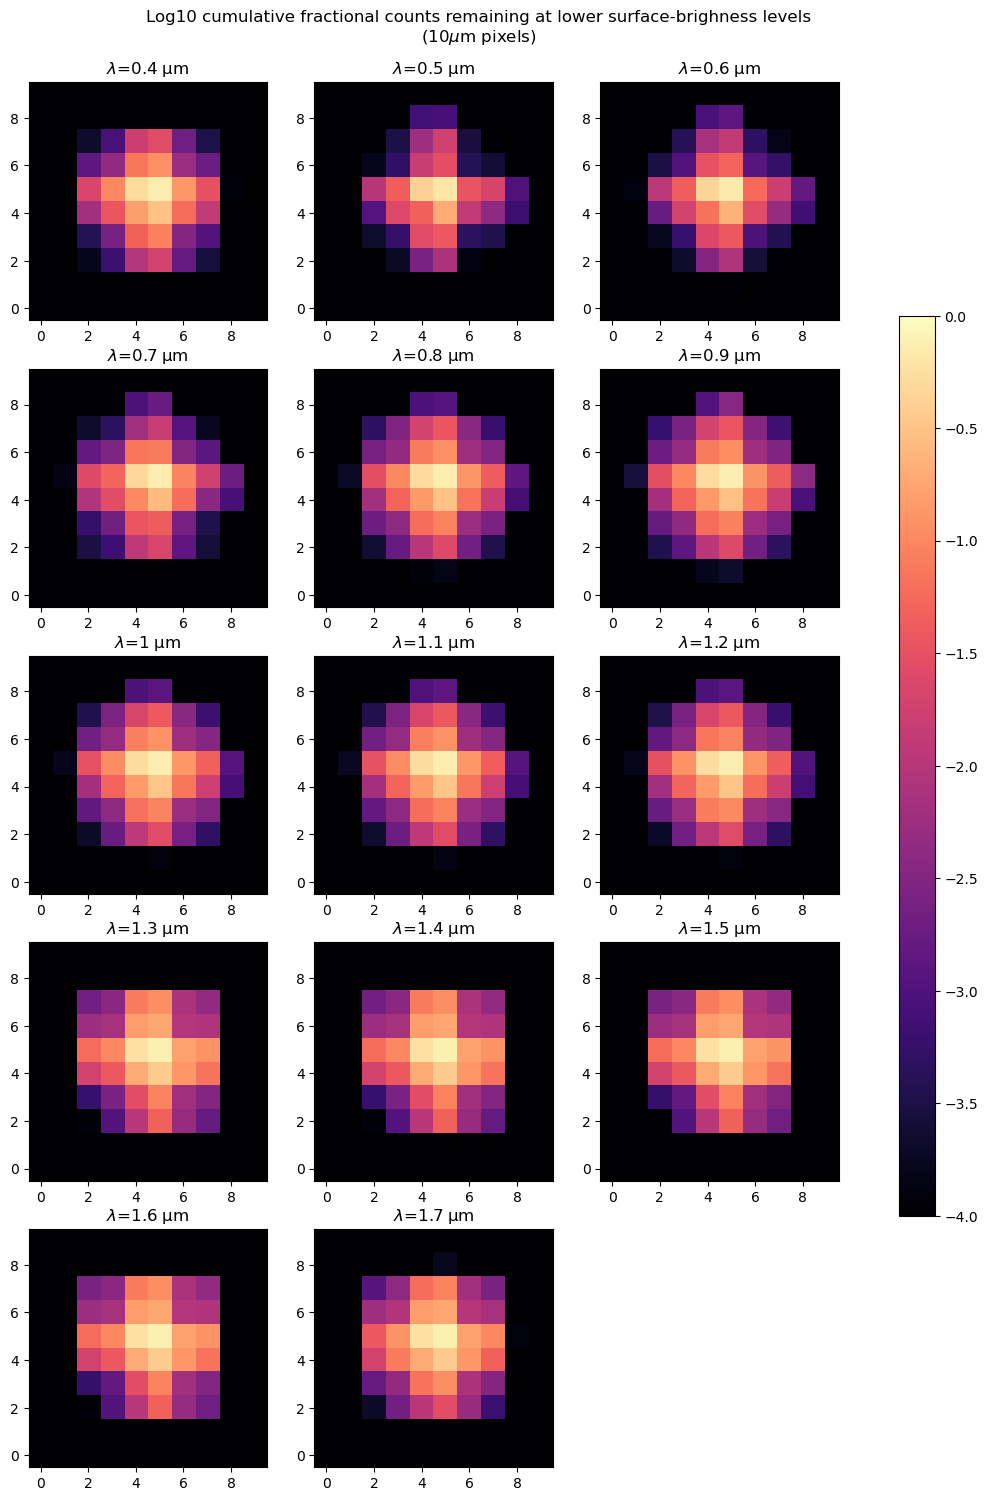

In [9]:
# Binned plot, log:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = cfrac_counts(skimage.measure.block_reduce(psf_stack[k].intensity, block_size=10, func=np.sum),
                              minfrac=1.e-8)
    ax = axis[j,i].imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Log10 cumulative fractional counts remaining at lower surface-brighness levels\n' +
                    '(10$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

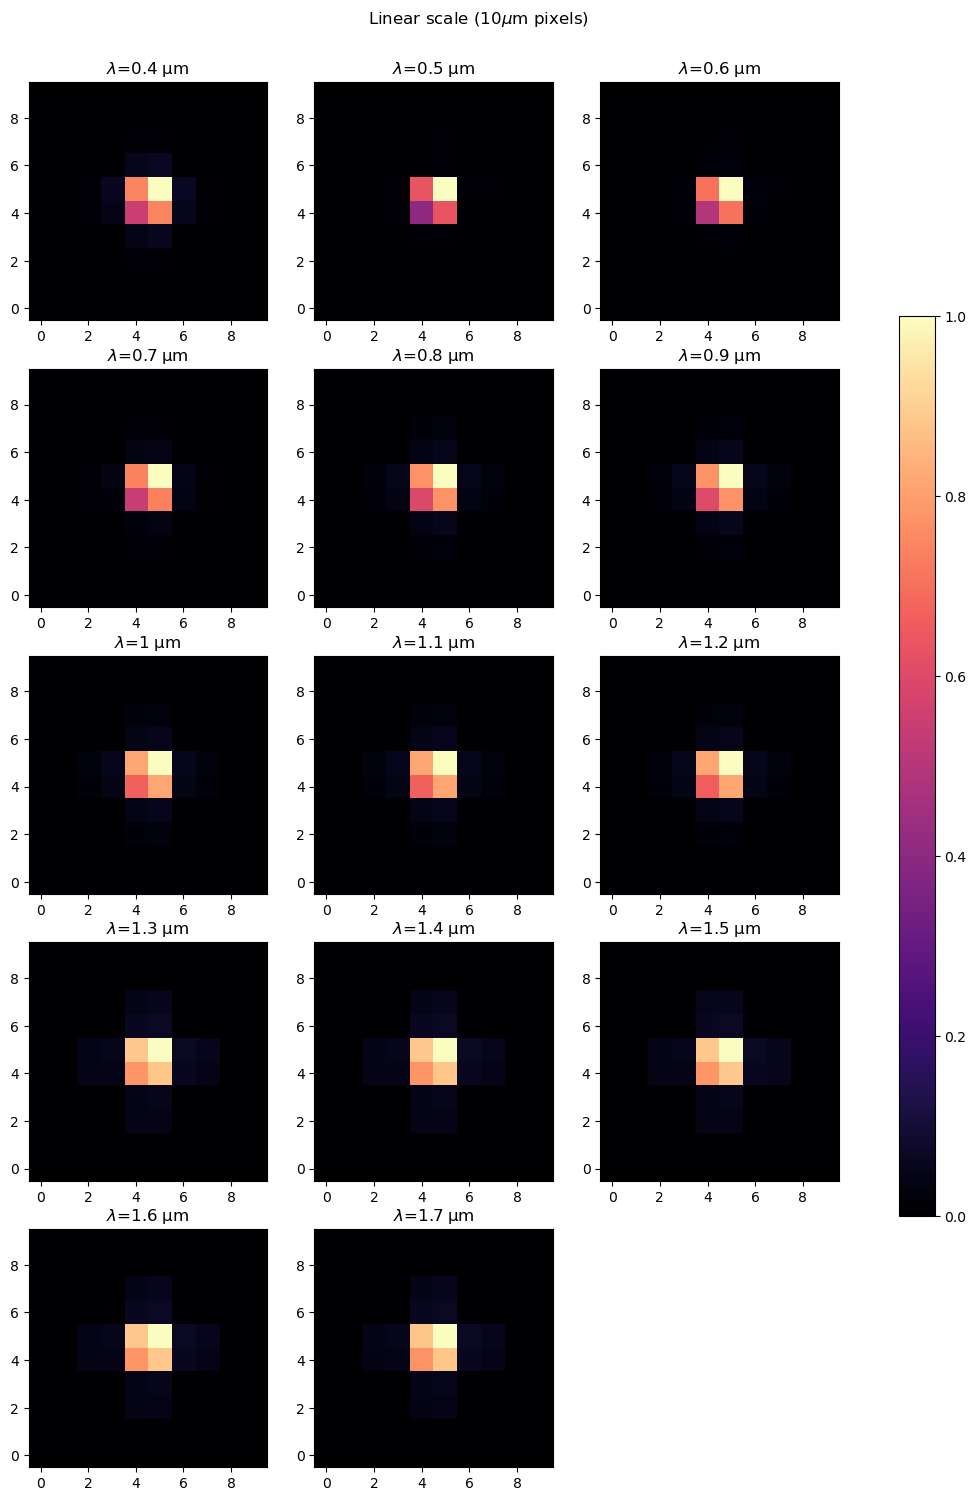

In [20]:
# Binned plot, linear:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = skimage.measure.block_reduce(psf_stack[k].intensity, block_size=10, func=np.sum)
    disp_image /= disp_image.max()
    ax = axis[j,i].imshow(disp_image, cmap='magma', vmin=0, vmax=1., interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Linear scale (10$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

### 5x5 grid of lenslets observing telescope PSF

The next two plots show the degree of stability of spectrograph PSF shape with changing position
of telescope PSF within the MLA for both 1.0$\mu$m (in the diffraction-dominated regime) and
04.$\mu$m (approaching the transitional regime).

At 1.0$\mu$m things look pretty good. Not perfectly stable, but not bad.

At 0.4$\mu$m it looks significantly worse. Again, this is where we are entering the transitional
regime. This effect might be model-able considering that any PSF will be very well centroided at
longer wavelengths.

In [11]:
# Compute 5x5 MLA grid, 1.0 micron wavelength

grid_hw = 2  # "half-width" of the lenslet grid in lenslets (2*grid_hw+1 is full width)
det_npix = int(detfov.value)  # integer dimension of detector in pixels
grid_npix = det_npix * (2 * grid_hw + 1)  # how many pixels total in the image
x_sub = 0.4 # x subspax offset of the PSF relative to the center of the central spaxel
y_sub = 0.2 # y subspax offset of the PSF relative to the center of the central spaxel
calc_wave = ref_wave  # wavelength for which to calculate

# Initialize mosaic grid:
psf_mosaic_t = np.full((grid_npix, grid_npix), 0.)  # y-dimension [comma] x-dimension

for y_this in range(2*grid_hw+1):
    y_shift = y_this - grid_hw + y_sub
    y_lo = (2*grid_hw - y_this) * det_npix      # Accommodate different
    y_hi = (2*grid_hw - y_this + 1) * det_npix  # beam orientations
    for x_this in range(2*grid_hw+1):
        x_shift = x_this - grid_hw + x_sub
        x_lo = (2*grid_hw - x_this) * det_npix
        x_hi = (2*grid_hw - x_this + 1) * det_npix
        print(x_shift, y_shift)
        sys_tiger[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                                  y_shift * spaxel_arcsec * u.arcsec)
        psf_t, fwave_t = sys_tiger.calc_psf(wavelength=calc_wave,
                                            display_intermediates=False,
                                            return_intermediates=False,
                                            return_final=True)
        psf_mosaic_t[y_lo:y_hi,x_lo:x_hi] = fwave_t[0].intensity

-1.6 -1.8
-0.6 -1.8
0.4 -1.8
1.4 -1.8
2.4 -1.8
-1.6 -0.8
-0.6 -0.8
0.4 -0.8
1.4 -0.8
2.4 -0.8
-1.6 0.2
-0.6 0.2
0.4 0.2
1.4 0.2
2.4 0.2
-1.6 1.2
-0.6 1.2
0.4 1.2
1.4 1.2
2.4 1.2
-1.6 2.2
-0.6 2.2
0.4 2.2
1.4 2.2
2.4 2.2


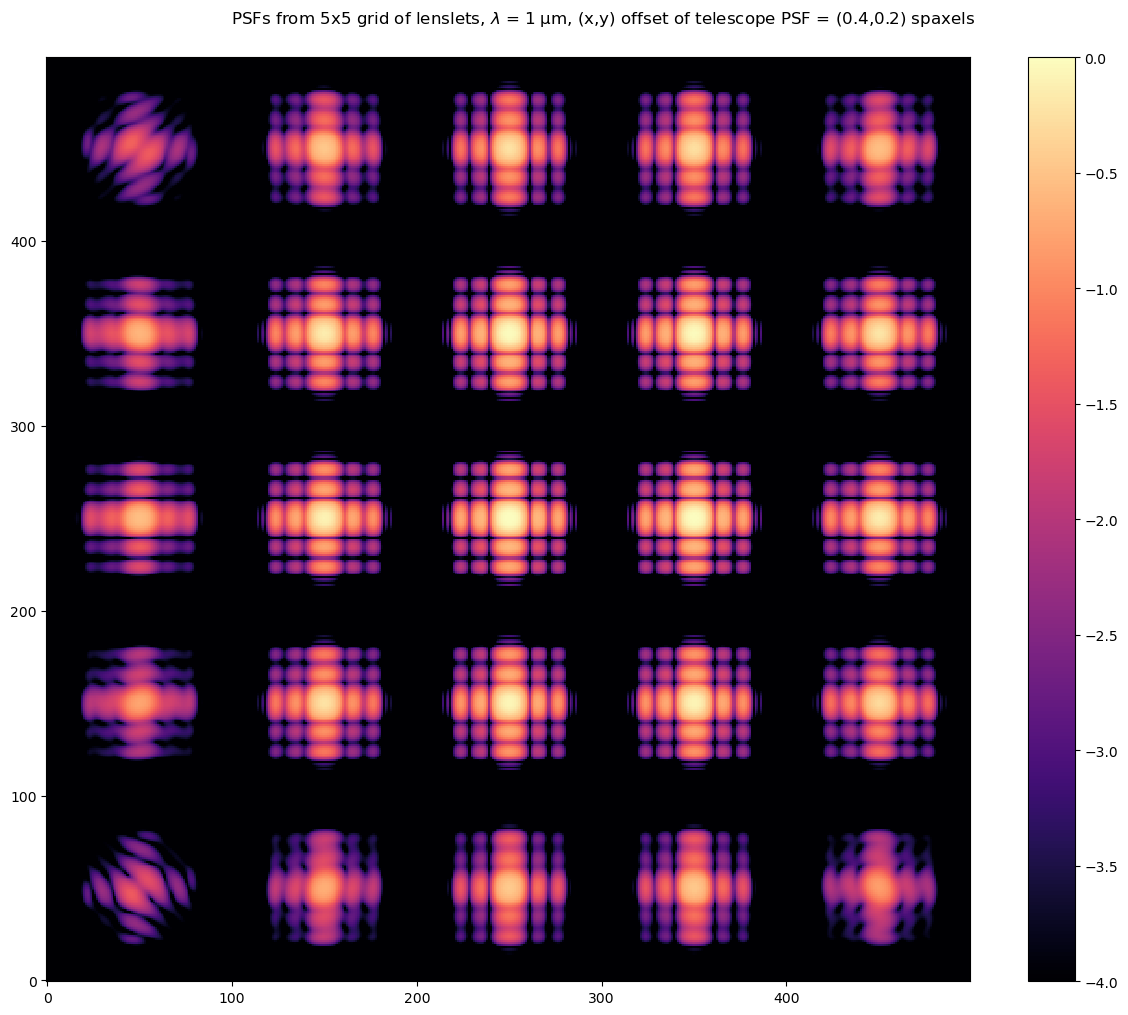

In [12]:
disp_image = cfrac_counts(psf_mosaic_t, minfrac=1.e-10)
plt.figure(figsize=(15,12))
plt.imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
plt.colorbar()
junk = plt.suptitle('PSFs from 5x5 grid of lenslets, $\lambda$ = ' +
                    calc_wave.to(u.micron).to_string(format='latex', precision=2) +
                    ', (x,y) offset of telescope PSF = ('+str(x_sub)+','+str(y_sub)+') spaxels', y=.92)

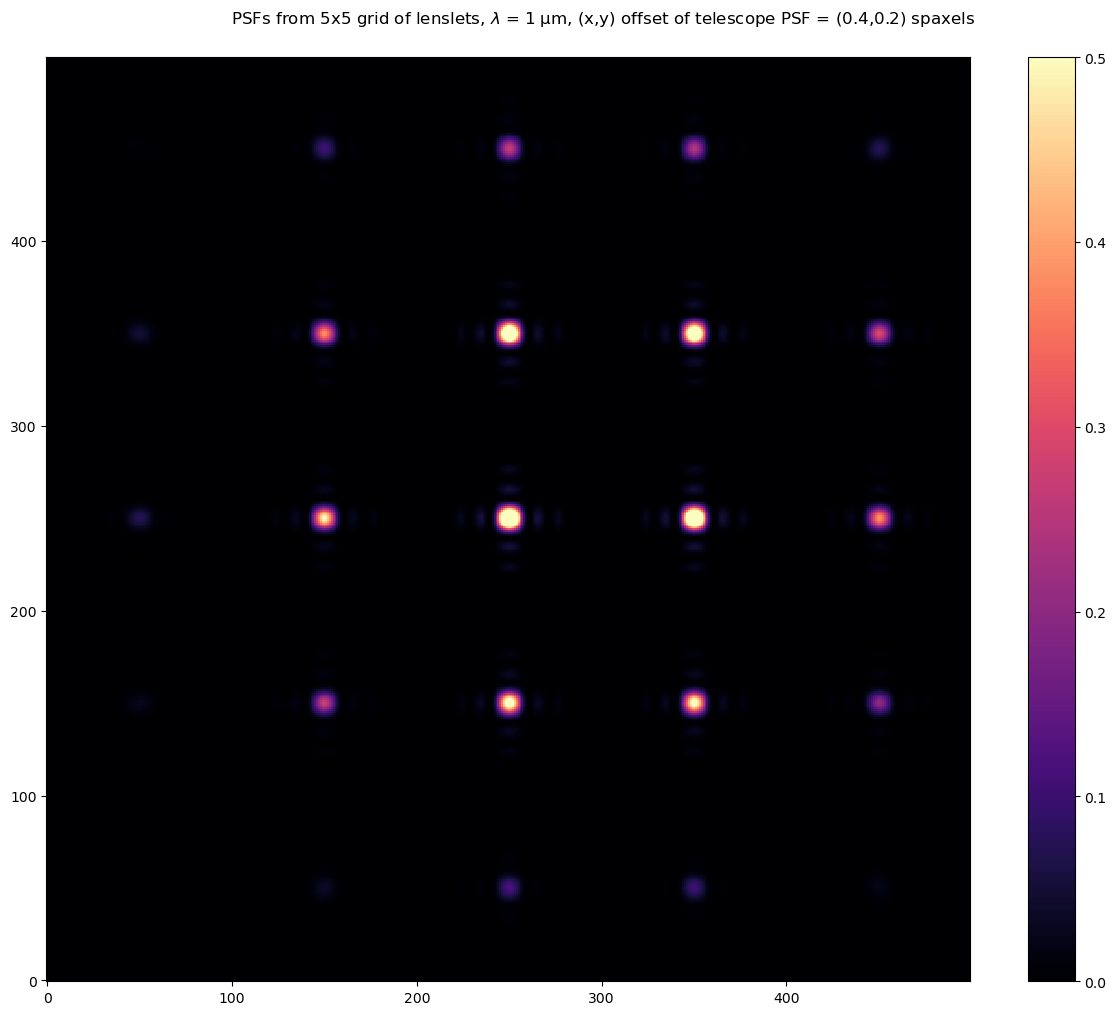

In [13]:
# Same plot, linear:
disp_image = psf_mosaic_t / psf_mosaic_t.max()
plt.figure(figsize=(15,12))
plt.imshow(disp_image, cmap='magma', vmin=0, vmax=0.5, interpolation='none', origin='lower')
plt.colorbar()
junk = plt.suptitle('PSFs from 5x5 grid of lenslets, $\lambda$ = ' +
                    calc_wave.to(u.micron).to_string(format='latex', precision=2) +
                    ', (x,y) offset of telescope PSF = ('+str(x_sub)+','+str(y_sub)+') spaxels', y=.92)

In [14]:
# Compute 5x5 MLA grid, 0.4 micron wavelength

grid_hw = 2  # "half-width" of the lenslet grid in lenslets (2*grid_hw+1 is full width)
det_npix = int(detfov.value)  # integer dimension of detector in pixels
grid_npix = det_npix * (2 * grid_hw + 1)  # how many pixels total in the image
x_sub = 0.4 # x subspax offset of the PSF relative to the center of the central spaxel
y_sub = 0.2 # y subspax offset of the PSF relative to the center of the central spaxel
calc_wave = 0.4 * u.micron  # wavelength for which to calculate

# Initialize mosaic grid:
psf_mosaic_t04 = np.full((grid_npix, grid_npix), 0.)  # y-dimension [comma] x-dimension

for y_this in range(2*grid_hw+1):
    y_shift = y_this - grid_hw + y_sub
    y_lo = (2*grid_hw - y_this) * det_npix      # Accommodate different
    y_hi = (2*grid_hw - y_this + 1) * det_npix  # beam orientations
    for x_this in range(2*grid_hw+1):
        x_shift = x_this - grid_hw + x_sub
        x_lo = (2*grid_hw - x_this) * det_npix
        x_hi = (2*grid_hw - x_this + 1) * det_npix
        print(x_shift, y_shift)
        sys_tiger[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                                  y_shift * spaxel_arcsec * u.arcsec)
        psf_t, fwave_t = sys_tiger.calc_psf(wavelength=calc_wave,
                                            display_intermediates=False,
                                            return_intermediates=False,
                                            return_final=True)
        psf_mosaic_t04[y_lo:y_hi,x_lo:x_hi] = fwave_t[0].intensity

-1.6 -1.8
-0.6 -1.8
0.4 -1.8
1.4 -1.8
2.4 -1.8
-1.6 -0.8
-0.6 -0.8
0.4 -0.8
1.4 -0.8
2.4 -0.8
-1.6 0.2
-0.6 0.2
0.4 0.2
1.4 0.2
2.4 0.2
-1.6 1.2
-0.6 1.2
0.4 1.2
1.4 1.2
2.4 1.2
-1.6 2.2
-0.6 2.2
0.4 2.2
1.4 2.2
2.4 2.2


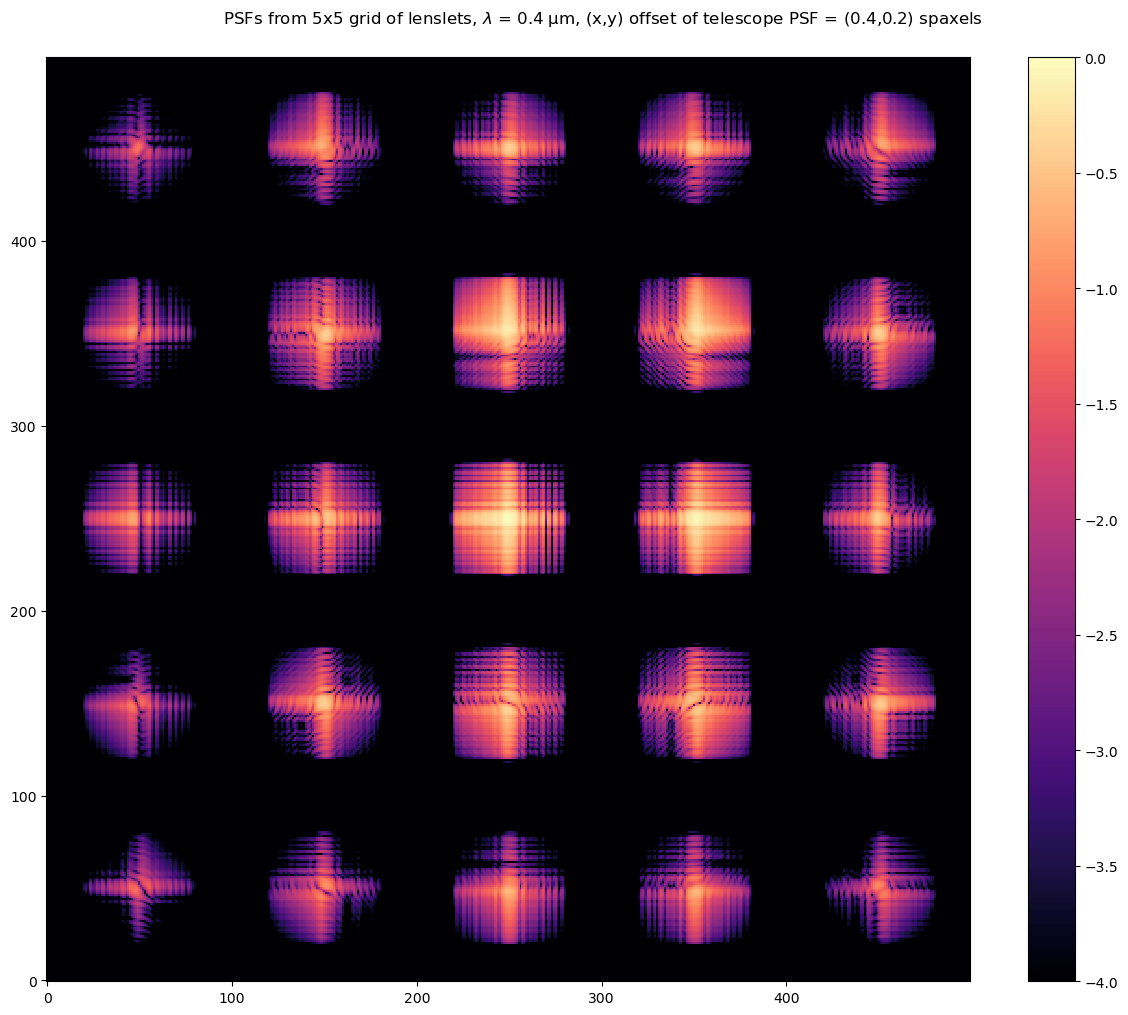

In [15]:
disp_image = cfrac_counts(psf_mosaic_t04, minfrac=1.e-10)
plt.figure(figsize=(15,12))
plt.imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
plt.colorbar()
junk = plt.suptitle('PSFs from 5x5 grid of lenslets, $\lambda$ = ' +
                    calc_wave.to(u.micron).to_string(format='latex', precision=2) +
                    ', (x,y) offset of telescope PSF = ('+str(x_sub)+','+str(y_sub)+') spaxels', y=.92)

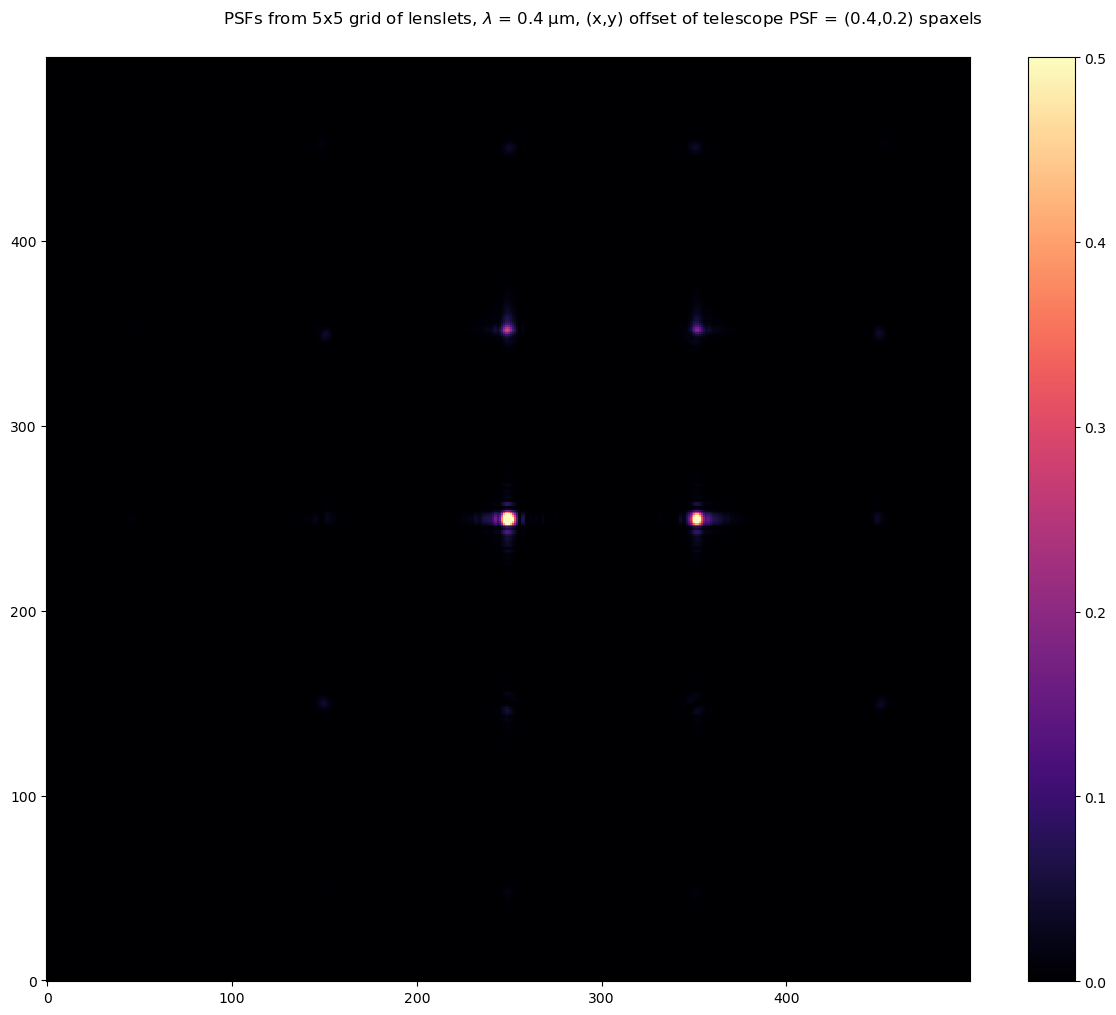

In [16]:
# same plot, linear:
disp_image = psf_mosaic_t04 / psf_mosaic_t04.max()
plt.figure(figsize=(15,12))
plt.imshow(disp_image, cmap='magma', vmin=0., vmax=0.5, interpolation='none', origin='lower')
plt.colorbar()
junk = plt.suptitle('PSFs from 5x5 grid of lenslets, $\lambda$ = ' +
                    calc_wave.to(u.micron).to_string(format='latex', precision=2) +
                    ', (x,y) offset of telescope PSF = ('+str(x_sub)+','+str(y_sub)+') spaxels', y=.92)

### What about 20, 40, or 80 milliarcsec lenslets?

To see what it looks like to transition to the pupil-dominated regime, we can consider
the same configuration fed by faster telescope+magnifier beams with more zoomed-out
spaxel scales of 20, 40, and 80 milliarcsec. This makes a comparison at fixed f-ratio
entering the spectrograph which is reasonably fair. The physical scale of
the micropupil increases to a maximum of 25$\mu$m (for the 80 mas setup), which is comparable
to the 20$\mu$m full width between first minima for the diffraction-regime case (i.e., these
images aren't being penalized by unfair "pupil bigness".)

The plots below show the PSF as a function of wavelength for these three alternatives. It isn't pretty. (Actually, it *is* pretty, but not in the way we want!)

For the case of 40 mas and 0.6$\mu$m, we also compute and plot a 3x3 lenslet grid with an offset telescope PSF.

I am not 100% confident that this is all free of numerical artifacts, but I don't think I'd want to work in this transitional regime.

We do see the pupil finally shine through at the shorter wavelengths of the 80 mas case, where we start to emerge into the geometric regime.

(Apologies for the boilerplate code below; I'll refactor at some point!)

### 20 mas case

In [21]:
spaxel_arcsec = 0.020
fl_pri = spaxel_size / (spaxel_arcsec / 206265.)
microp_size = imdist_tiger * (diam / fl_pri) # Diameter of micropupil image (COMPUTED)

print("Telescope focal length (eff)   = ", fl_pri.to_string(precision=1))
print("Spaxel angular size on sky     = ", (1000.*spaxel_arcsec * u.milliarcsecond).to_string(precision=2))
print("Geometric size of micropupil   = ", microp_size.to(u.micron).to_string(precision=3))
print("Microlens emerging f-ratio     = ", (imdist_tiger/spaxel_size).to_string(precision=1))

Telescope focal length (eff)   =  7159.8 m
Spaxel angular size on sky     =  20.00 marcsec
Geometric size of micropupil   =  6.303 micron
Microlens emerging f-ratio     =  10.0


In [22]:
sys_tiger = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_tiger.add_optic(ttstage)
# Include secondary obscuration:
sys_tiger.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_tiger.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_tiger.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Tiger MLA aperture'))
# Add MLA lens:
sys_tiger.add_optic(poppy.QuadraticLens(fl_tiger, name='Tiger MLA lens'))
# Define micropupil image plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Tiger micropupil plane'),
                    distance=imdist_tiger)
# Add diaphragm mask:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_tiger,  ### <---FIX?!
                                          name='Tiger diaphragm mask'))
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add reference plane at location of first prism surface:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='First prism surface'),
                    distance=pr_dist)
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=(imdist_spec-pr_dist))
# Add spectrograph M2 aperture:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=imdist_spec)
# Add "detector":
sys_tiger.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_tiger.planes)):
    sys_tiger.planes[iplane].wavefront_display_hint = 'intensity'

In [23]:
test_lam = [this_lam * u.micron for this_lam in np.linspace(.4,1.7,14)]
psf_stack_20 = []
for this_lam in test_lam:
    print(this_lam)
    this_psf, this_wave = sys_tiger.calc_psf(wavelength=this_lam, return_final=True)
    psf_stack_20.append(this_wave[0])

0.4 micron
0.5 micron
0.6 micron
0.7 micron
0.8 micron
0.8999999999999999 micron
1.0 micron
1.1 micron
1.2 micron
1.2999999999999998 micron
1.4 micron
1.5 micron
1.6 micron
1.7 micron


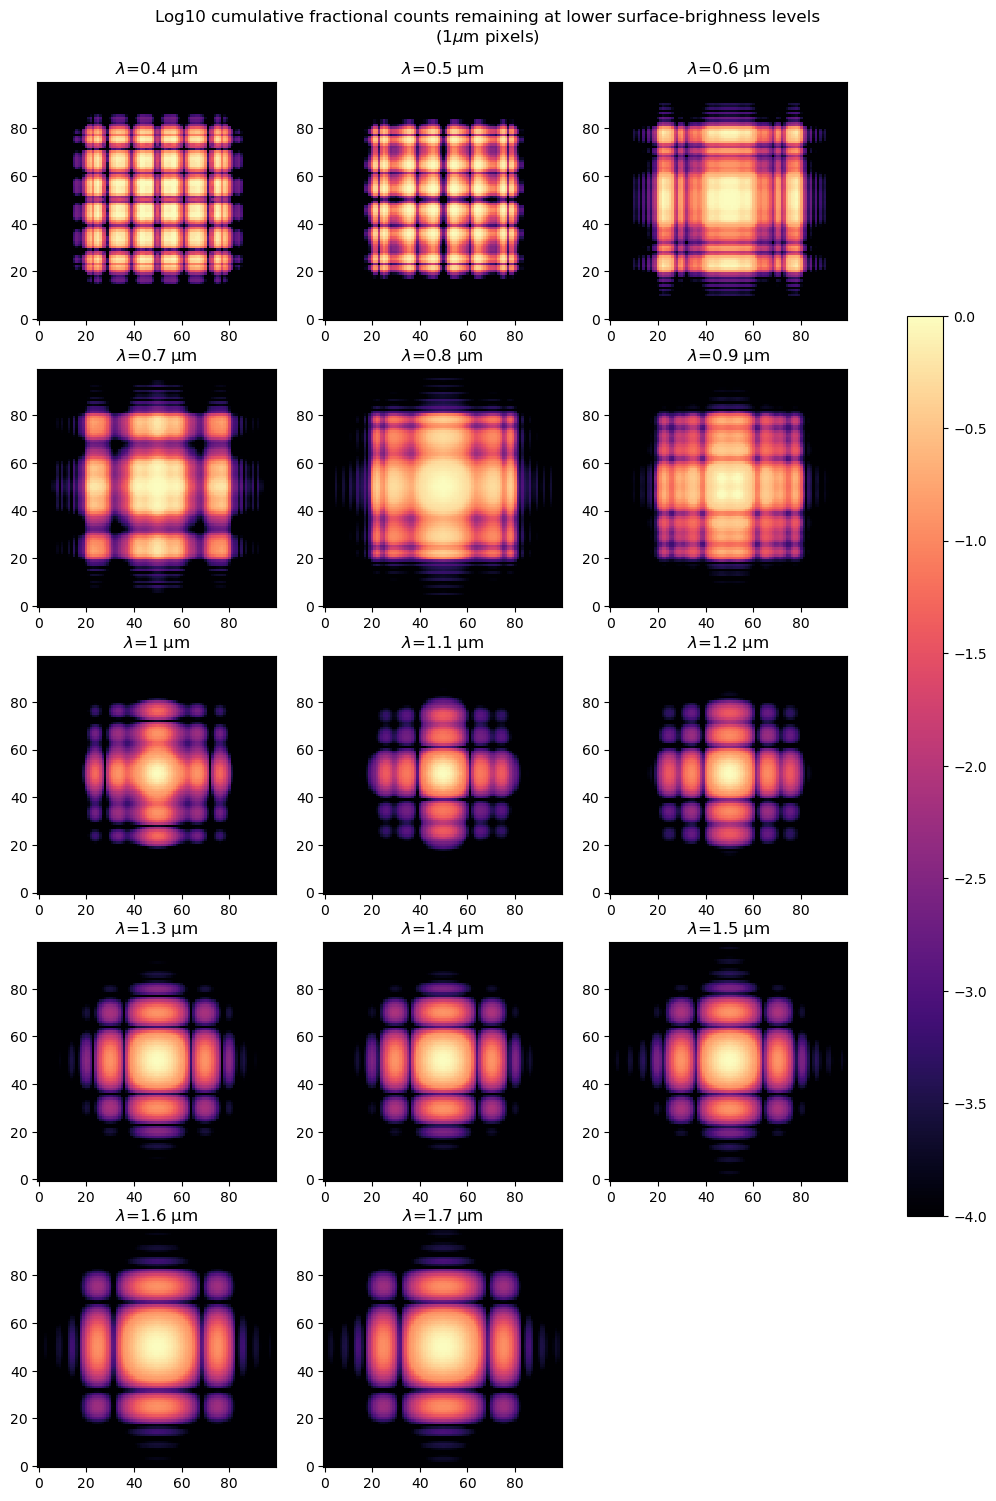

In [24]:
# Log-histeq plot:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = cfrac_counts(psf_stack_20[k].intensity, minfrac=1.e-10)
    ax = axis[j,i].imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Log10 cumulative fractional counts remaining at lower surface-brighness levels\n' +
                    '(1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

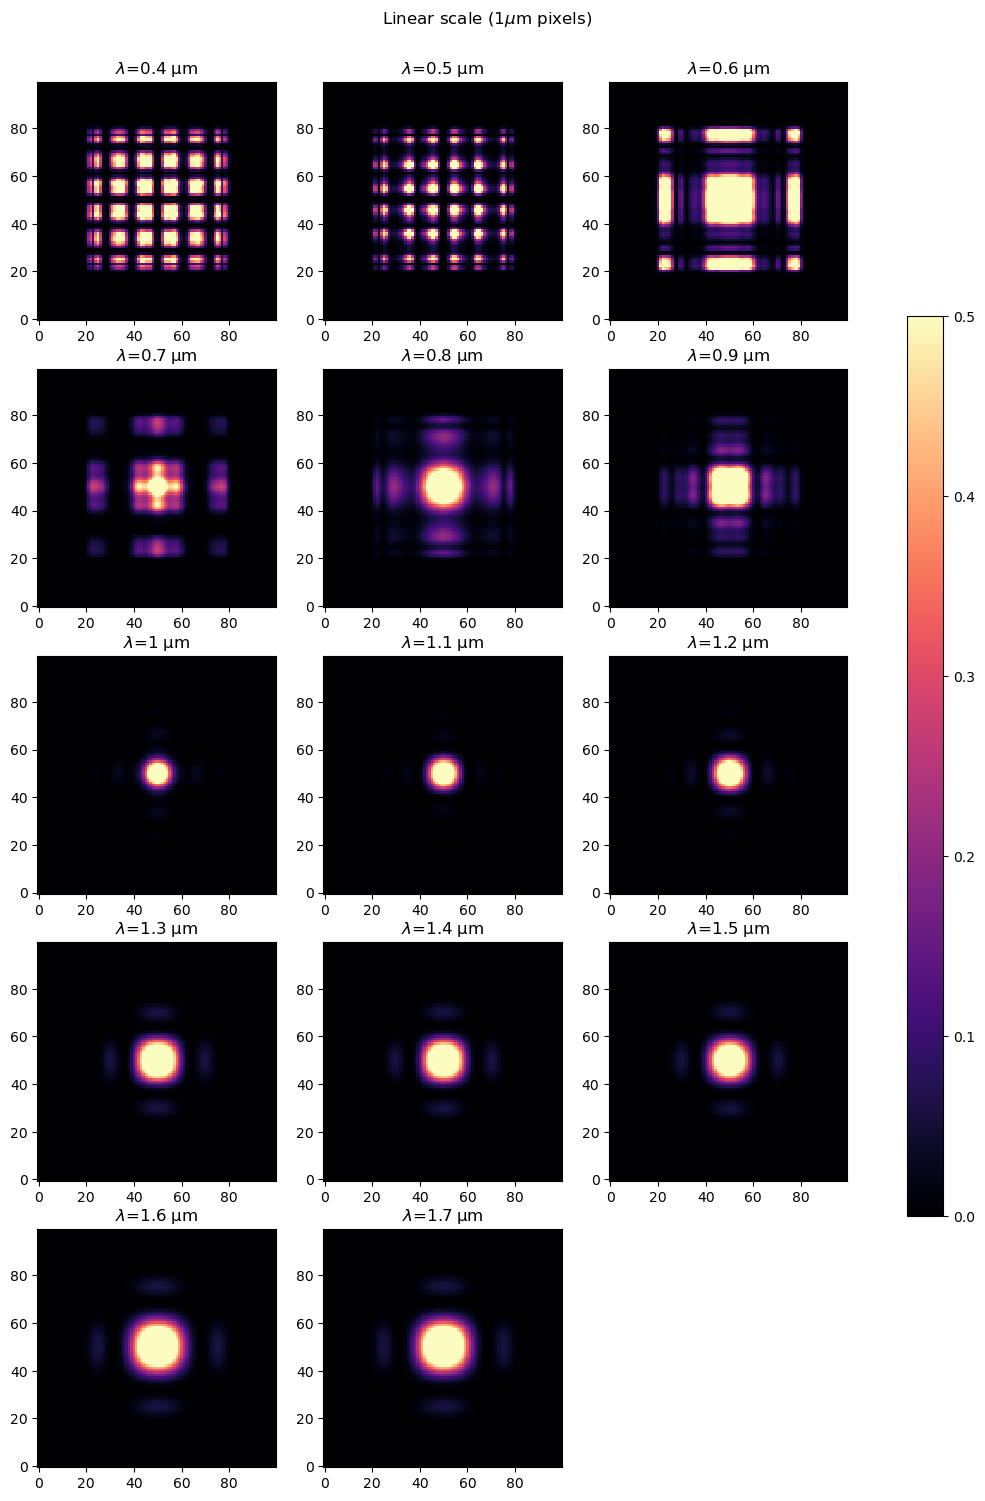

In [26]:
# Linear plot:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = psf_stack_20[k].intensity
    disp_image /= disp_image.max()
    ax = axis[j,i].imshow(disp_image, cmap='magma', vmin=0, vmax=0.5, interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Linear scale (1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

### 40 mas case

In [42]:
spaxel_arcsec = 0.040
fl_pri = spaxel_size / (spaxel_arcsec / 206265.)
microp_size = imdist_tiger * (diam / fl_pri) # Diameter of micropupil image (COMPUTED)

print("Telescope focal length (eff)   = ", fl_pri.to_string(precision=1))
print("Spaxel angular size on sky     = ", (1000.*spaxel_arcsec * u.milliarcsecond).to_string(precision=2))
print("Geometric size of micropupil   = ", microp_size.to(u.micron).to_string(precision=3))
print("Microlens emerging f-ratio     = ", (imdist_tiger/spaxel_size).to_string(precision=1))

Telescope focal length (eff)   =  3579.9 m
Spaxel angular size on sky     =  40.00 marcsec
Geometric size of micropupil   =  12.605 micron
Microlens emerging f-ratio     =  10.0


In [43]:
sys_tiger = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_tiger.add_optic(ttstage)
# Include secondary obscuration:
sys_tiger.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_tiger.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_tiger.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Tiger MLA aperture'))
# Add MLA lens:
sys_tiger.add_optic(poppy.QuadraticLens(fl_tiger, name='Tiger MLA lens'))
# Define micropupil image plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Tiger micropupil plane'),
                    distance=imdist_tiger)
# Add diaphragm mask:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_tiger,  ### <---FIX?!
                                          name='Tiger diaphragm mask'))
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add reference plane at location of first prism surface:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='First prism surface'),
                    distance=pr_dist)
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=(imdist_spec-pr_dist))
# Add spectrograph M2 aperture:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=imdist_spec)
# Add "detector":
sys_tiger.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_tiger.planes)):
    sys_tiger.planes[iplane].wavefront_display_hint = 'intensity'

In [29]:
test_lam = [this_lam * u.micron for this_lam in np.linspace(.4,1.7,14)]
psf_stack_40 = []
for this_lam in test_lam:
    print(this_lam)
    this_psf, this_wave = sys_tiger.calc_psf(wavelength=this_lam, return_final=True)
    psf_stack_40.append(this_wave[0])

0.4 micron
0.5 micron
0.6 micron
0.7 micron
0.8 micron
0.8999999999999999 micron
1.0 micron
1.1 micron
1.2 micron
1.2999999999999998 micron
1.4 micron
1.5 micron
1.6 micron
1.7 micron


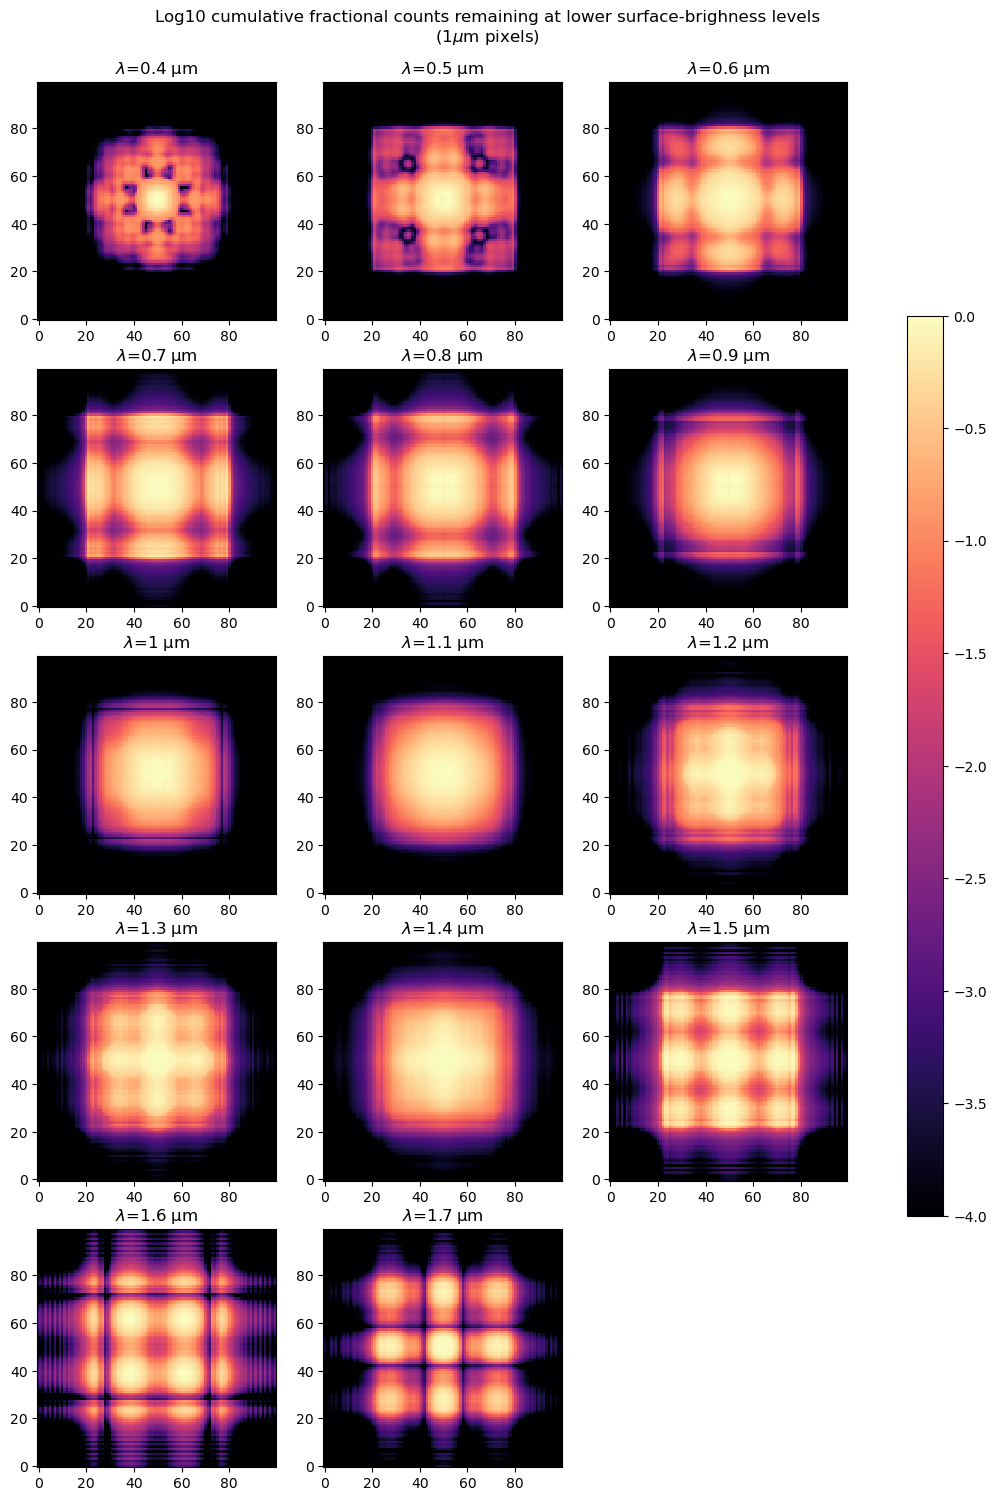

In [30]:
# Log-histeq plot:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = cfrac_counts(psf_stack_40[k].intensity, minfrac=1.e-10)
    ax = axis[j,i].imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Log10 cumulative fractional counts remaining at lower surface-brighness levels\n' +
                    '(1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

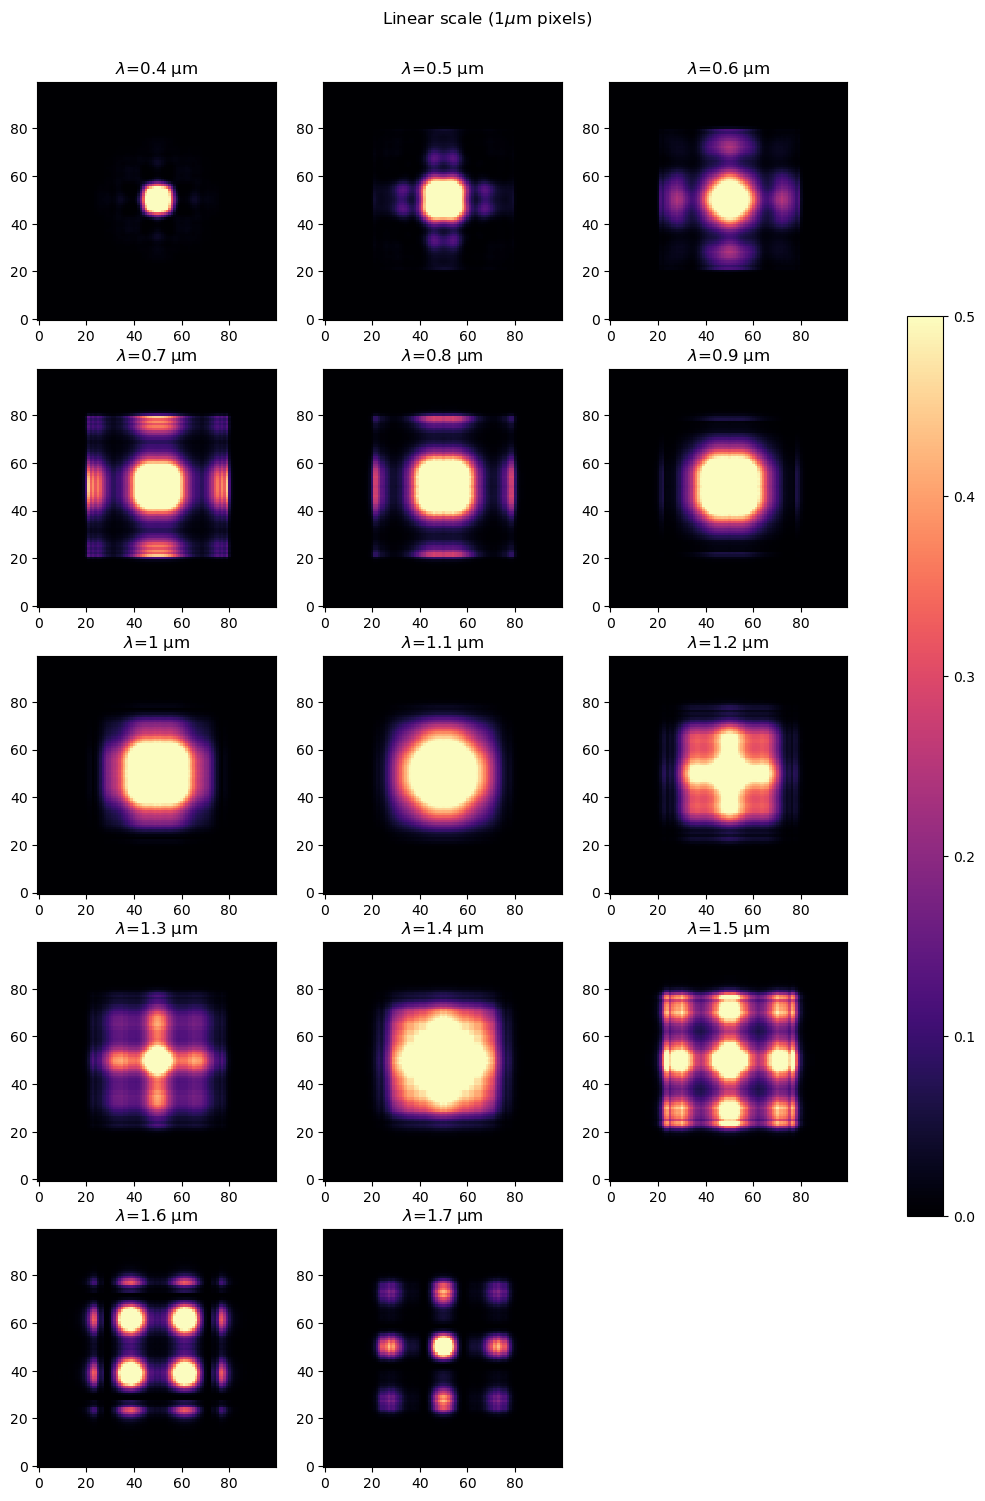

In [31]:
# Linear plot:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = psf_stack_40[k].intensity
    disp_image /= disp_image.max()
    ax = axis[j,i].imshow(disp_image, cmap='magma', vmin=0., vmax=0.5, interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Linear scale (1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

In [32]:
# Compute 3x3 MLA grid for this case

grid_hw = 1  # "half-width" of the lenslet grid in lenslets (2*grid_hw+1 is full width)
det_npix = int(detfov.value)  # integer dimension of detector in pixels
grid_npix = det_npix * (2 * grid_hw + 1)  # how many pixels total in the image
x_sub = 0.4 # x subspax offset of the PSF relative to the center of the central spaxel
y_sub = 0.2 # y subspax offset of the PSF relative to the center of the central spaxel
calc_wave = 0.6 * u.micron  # wavelength for which to calculate

# Initialize mosaic grid:
psf_mosaic_t = np.full((grid_npix, grid_npix), 0.)  # y-dimension [comma] x-dimension

for y_this in range(2*grid_hw+1):
    y_shift = y_this - grid_hw + y_sub
    y_lo = (2*grid_hw - y_this) * det_npix      # Accommodate different
    y_hi = (2*grid_hw - y_this + 1) * det_npix  # beam orientations
    for x_this in range(2*grid_hw+1):
        x_shift = x_this - grid_hw + x_sub
        x_lo = (2*grid_hw - x_this) * det_npix
        x_hi = (2*grid_hw - x_this + 1) * det_npix
        print(x_shift, y_shift)
        sys_tiger[0].set_tip_tilt(x_shift * spaxel_arcsec * u.arcsec,
                                  y_shift * spaxel_arcsec * u.arcsec)
        psf_t, fwave_t = sys_tiger.calc_psf(wavelength=calc_wave,
                                            display_intermediates=False,
                                            return_intermediates=False,
                                            return_final=True)
        psf_mosaic_t[y_lo:y_hi,x_lo:x_hi] = fwave_t[0].intensity

-0.6 -0.8
0.4 -0.8
1.4 -0.8
-0.6 0.2
0.4 0.2
1.4 0.2
-0.6 1.2
0.4 1.2
1.4 1.2


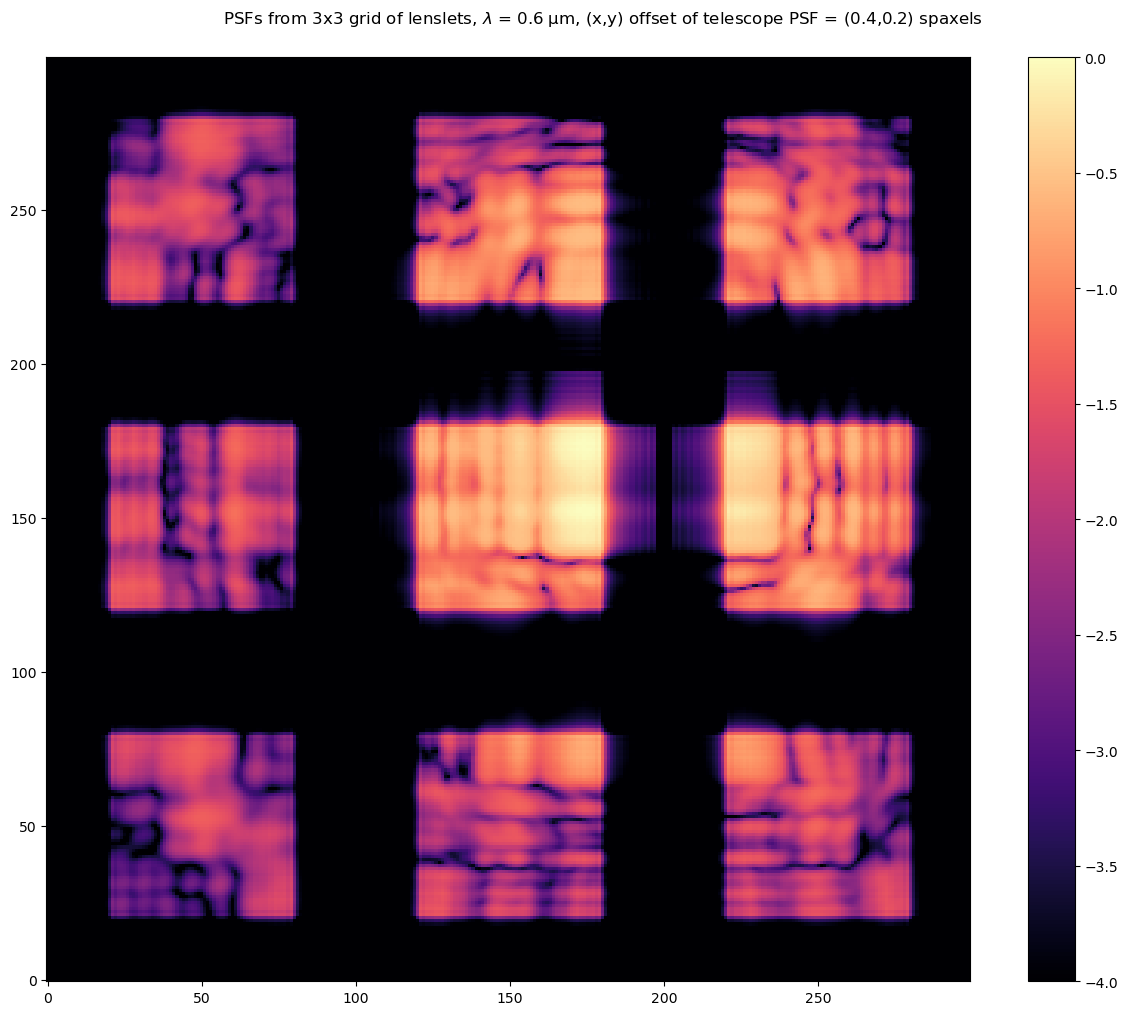

In [37]:
disp_image = cfrac_counts(psf_mosaic_t, minfrac=1.e-10)
plt.figure(figsize=(15,12))
plt.imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
plt.colorbar()
junk = plt.suptitle('PSFs from 3x3 grid of lenslets, $\lambda$ = ' +
                    calc_wave.to(u.micron).to_string(format='latex', precision=2) +
                    ', (x,y) offset of telescope PSF = ('+str(x_sub)+','+str(y_sub)+') spaxels', y=.92)

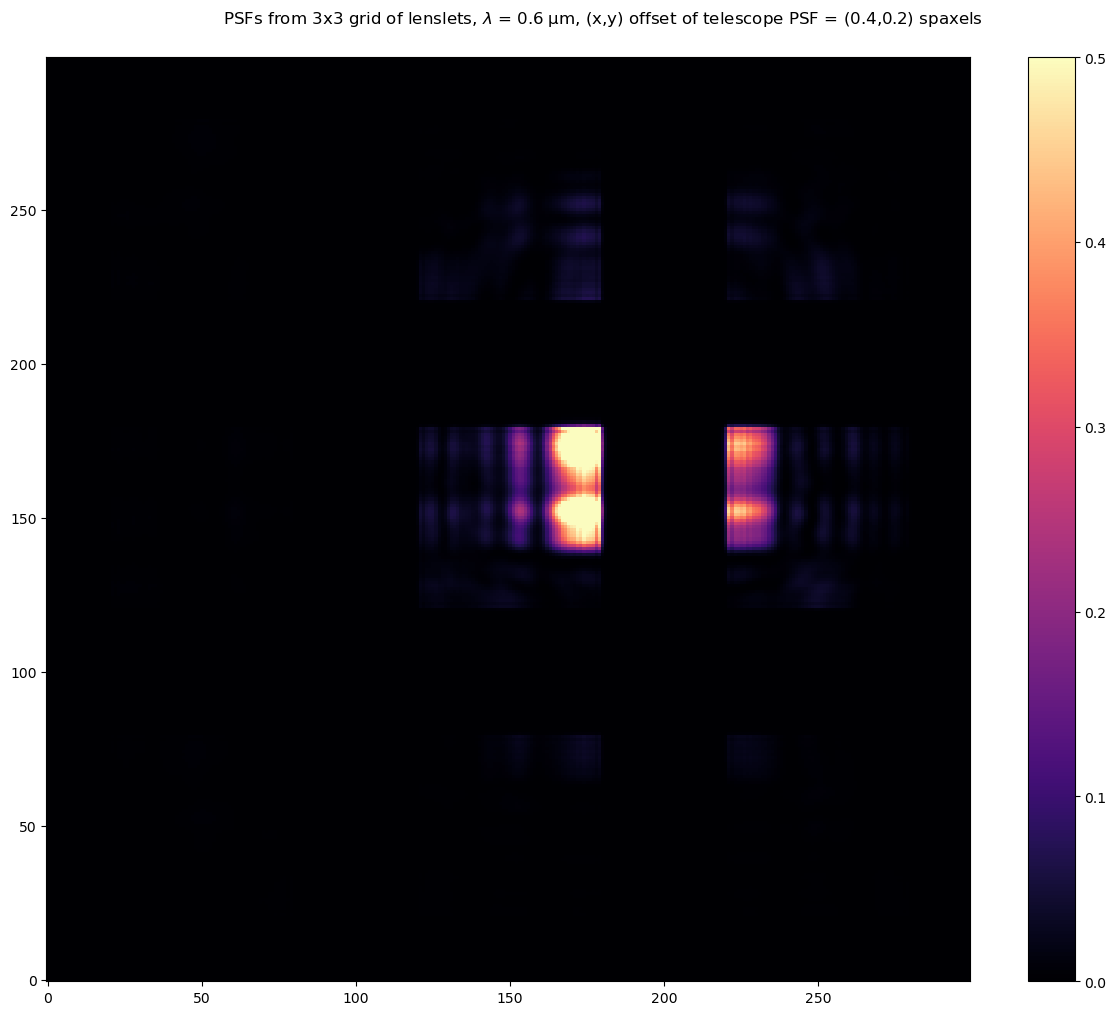

In [41]:
# Linear version:
disp_image = psf_mosaic_t / psf_mosaic_t.max()
plt.figure(figsize=(15,12))
plt.imshow(disp_image, cmap='magma', vmin=0., vmax=0.5, interpolation='none', origin='lower')
plt.colorbar()
junk = plt.suptitle('PSFs from 3x3 grid of lenslets, $\lambda$ = ' +
                    calc_wave.to(u.micron).to_string(format='latex', precision=2) +
                    ', (x,y) offset of telescope PSF = ('+str(x_sub)+','+str(y_sub)+') spaxels', y=.92)

### 80 mas case

In [44]:
spaxel_arcsec = 0.080
fl_pri = spaxel_size / (spaxel_arcsec / 206265.)
microp_size = imdist_tiger * (diam / fl_pri) # Diameter of micropupil image (COMPUTED)

print("Telescope focal length (eff)   = ", fl_pri.to_string(precision=1))
print("Spaxel angular size on sky     = ", (1000.*spaxel_arcsec * u.milliarcsecond).to_string(precision=2))
print("Geometric size of micropupil   = ", microp_size.to(u.micron).to_string(precision=3))
print("Microlens emerging f-ratio     = ", (imdist_tiger/spaxel_size).to_string(precision=1))

Telescope focal length (eff)   =  1790.0 m
Spaxel angular size on sky     =  80.00 marcsec
Geometric size of micropupil   =  25.210 micron
Microlens emerging f-ratio     =  10.0


In [45]:
sys_tiger = poppy.FresnelOpticalSystem(pupil_diameter=pupil_diam, npix=npix)
# Primary aperture:
prim_ap = poppy.CircularAperture(radius=diam/2.)
# Tip-tilt stage (to walk telescope PSF over spaxel):
ttstage = poppy.TipTiltStage(prim_ap, radius=diam/2.)
# Put primary+stage into system:
sys_tiger.add_optic(ttstage)
# Include secondary obscuration:
sys_tiger.add_optic(poppy.SecondaryObscuration(secondary_radius=sec_rad,
                                               n_supports=n_supp,
                                               support_width=supp_wid))
# Add lens to represent focusing effect of primary + magnifier:
sys_tiger.add_optic(poppy.QuadraticLens(fl_pri, name='Primary'))
# Establish telescope focal plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image,
                                             name='Telescope focal plane'),
                    distance=fl_pri)
# Add MLA aperture:
sys_tiger.add_optic(poppy.SquareFieldStop(size=1.*spaxel_arcsec,  ### <---FIX?!
                                          name='Tiger MLA aperture'))
# Add MLA lens:
sys_tiger.add_optic(poppy.QuadraticLens(fl_tiger, name='Tiger MLA lens'))
# Define micropupil image plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Tiger micropupil plane'),
                    distance=imdist_tiger)
# Add diaphragm mask:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_tiger,  ### <---FIX?!
                                          name='Tiger diaphragm mask'))
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add reference plane at location of first prism surface:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='First prism surface'),
                    distance=pr_dist)
sys_tiger.planes[-1].wavefront_display_hint = 'intensity'
# Add spectrograph M1:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M1'),
                    distance=(imdist_spec-pr_dist))
# Add spectrograph M2 aperture:
sys_tiger.add_optic(poppy.SquareAperture(size=1.*dsize_m2,  ### <---FIX?!
                                          name='Spectro. M2 (aper)'),
                    distance=offset_m2)
# Add spectrograph M2 optical power:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m2, name='Spectro. M2 (optic)'))
# Add spectrograph M3:
sys_tiger.add_optic(poppy.QuadraticLens(fl_m1m3, name='Spectrograph M3'),
                    distance=offset_m2)
# Establish detector plane:
sys_tiger.add_optic(poppy.ScalarTransmission(planetype=PlaneType.intermediate,
                                             name='Spectrograph focal plane'),
                    distance=imdist_spec)
# Add "detector":
sys_tiger.add_detector(pixelscale=detscale, fov_pixels=detfov)

# Make everything display intensity:
for iplane in range(len(sys_tiger.planes)):
    sys_tiger.planes[iplane].wavefront_display_hint = 'intensity'

In [46]:
test_lam = [this_lam * u.micron for this_lam in np.linspace(.4,1.7,14)]
psf_stack_80 = []
for this_lam in test_lam:
    print(this_lam)
    this_psf, this_wave = sys_tiger.calc_psf(wavelength=this_lam, return_final=True)
    psf_stack_80.append(this_wave[0])

0.4 micron
0.5 micron
0.6 micron
0.7 micron
0.8 micron
0.8999999999999999 micron
1.0 micron
1.1 micron
1.2 micron
1.2999999999999998 micron
1.4 micron
1.5 micron
1.6 micron
1.7 micron


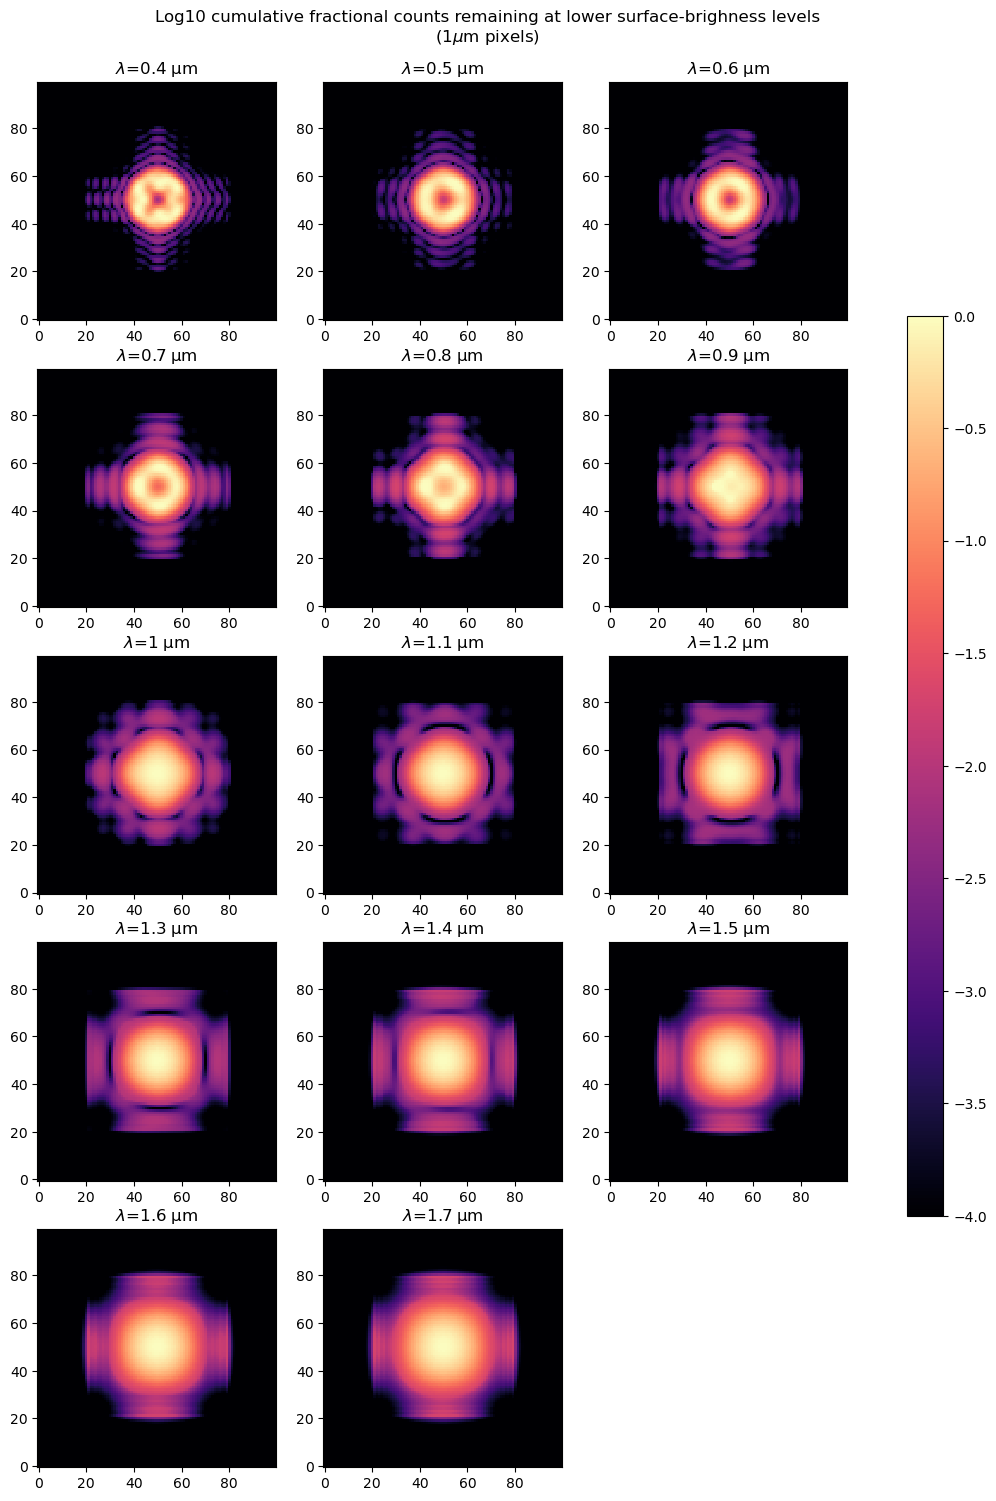

In [47]:
# Make unbinned plot:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = cfrac_counts(psf_stack_80[k].intensity, minfrac=1.e-10)
    ax = axis[j,i].imshow(np.log10(disp_image), cmap='magma', vmin=-4., vmax=0., interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Log10 cumulative fractional counts remaining at lower surface-brighness levels\n' +
                    '(1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)

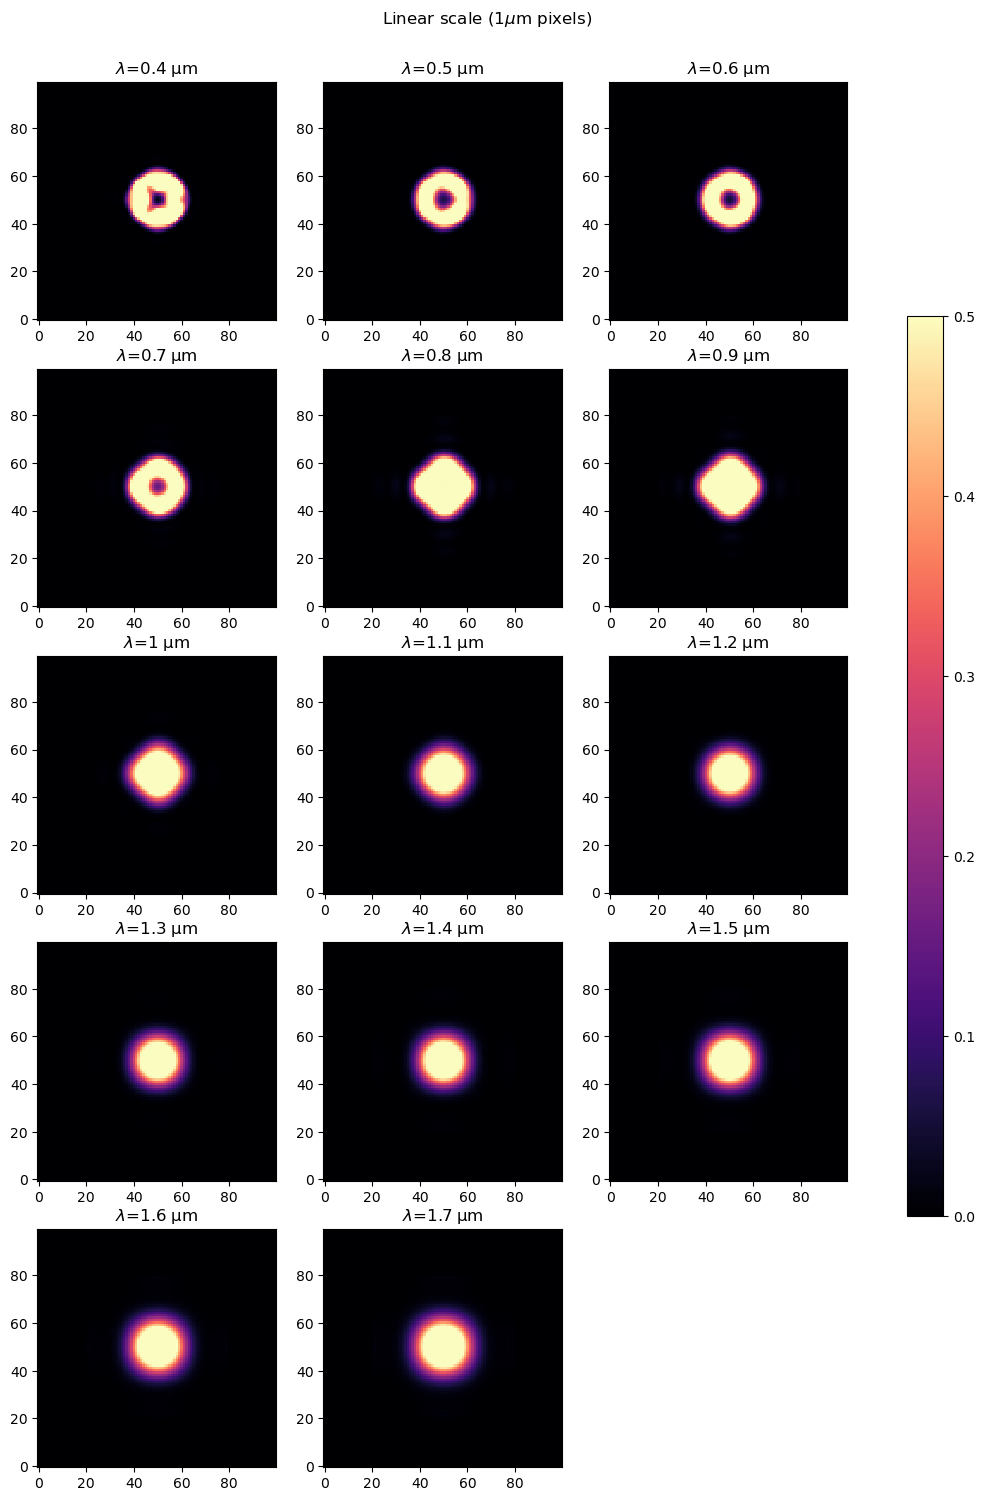

In [48]:
# Same plot, linear:
n_x = 3
n_y = 5
fig, axis = plt.subplots(n_y, n_x)#, sharex=True, sharey=True)
for k in range(len(test_lam)):
    i = k % n_x
    j = k // n_x
    axis[j,i].set_box_aspect(1)
    disp_image = psf_stack_80[k].intensity
    disp_image /= disp_image.max()
    ax = axis[j,i].imshow(disp_image, cmap='magma', vmin=0., vmax=0.5, interpolation='none', origin='lower')
    axis[j,i].set_title('$\lambda$='+test_lam[k].to_string(format='latex', precision=2))

#axis[3,2].axis('off')
#axis[3,3].axis('off')
axis[4,2].axis('off')

fig.set_figwidth(12)
fig.set_figheight(18)
junk = fig.suptitle('Linear scale (1$\mu$m pixels)', y=.92)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.03, 0.5])
fig.colorbar(ax, cax=cbar_ax)